# Structure of the notebook

This notebook utilizes the cleaned dataset of the taxi trip record data.

The notebook sets the basis for **Chapter 3.3 Exploratory Data Analysis:**
<ul>
    <li>Temporal Analysis of MOD Trip Requests (Chapter 3.3.1)</li>
    <li>Spatial Analysis of MOD Trip Requests (Chapter 3.3.2)</li>
</ul>

# Libraries required to run this notebook

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from matplotlib.ticker import LinearLocator, MultipleLocator
from matplotlib import colors
import seaborn as sns
import numpy as np
import statistics
import matplotlib.dates as mdates
! pip install -q geopandas
import geopandas as gpd
! pip install -q contextily
import contextily as ctx
import warnings
warnings.filterwarnings("ignore")
import math

from shapely.geometry import Polygon
! pip install -q descartes
from descartes.patch import PolygonPatch

# Data reading and initial exploration

In [2]:
# Only the columns were loaded that are required for the investigation of spatiotemporal patterns
taxi_data_outl = pd.read_parquet("gs://taxi_data_outl/taxi_data_outl.parquet", columns = ['tpep_pickup_datetime', 'PULocationID', 'DOLocationID'])

In [6]:
# First glance at the data
taxi_data_outl.sample(10)

,tpep_pickup_datetime,PULocationID,DOLocationID
7617294,2022-03-20 11:58:43,132,25
11423730,2022-04-21 14:25:23,239,166
3534455,2022-02-11 20:26:51,140,234
15237966,2022-05-23 15:47:41,237,140
1939391,2022-01-26 08:35:37,158,211
1439028,2022-01-20 11:24:35,140,262
5146869,2022-02-27 00:48:42,162,48
19078040,2022-06-25 11:33:38,88,161
10911954,2022-04-16 19:10:15,79,113
11591348,2022-04-22 20:26:01,166,234


In [3]:
# Helper variables to facilitate the visual analysis

# Extract the pickup month from the datetime column
taxi_data_outl['PU_month'] = taxi_data_outl['tpep_pickup_datetime'].dt.month.astype(np.uint8)

# Extract the pickup day of the month from the datetime column
taxi_data_outl['PU_day_of_month'] = taxi_data_outl['tpep_pickup_datetime'].dt.day.astype(np.uint8)

# Extract the pickup day of the week (0-6) from the datetime column
taxi_data_outl['PU_day_of_week'] = taxi_data_outl['tpep_pickup_datetime'].dt.weekday.astype(np.uint8)

# Extract the pickup hour from the datetime column
taxi_data_outl['PU_hour'] = taxi_data_outl['tpep_pickup_datetime'].dt.hour.astype(np.uint8)

# Definition of a list of day of the week names
PU_day_of_week_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Definition of a list of month names
PU_month_names = ['January', 'February', 'March', 'April', 'May', 'June']

In addition, 4 time zones were created representing the time of the day: 

<ul>
    <li>Morning 6:00 am - 11:59 pm</li>
    <li>Afternoon 12:00 pm - 3:59 pm</li>
    <li>Evening 4:00 pm - 9:59 pm</li>
    <li>Late Night 10:00 pm - 5:59 am</li>
</ul>

In [4]:
# Definition of a function to classify the time of day based on the pickup hour
def time_of_day(x):
    if x in range (6,12):
        return 'Morning'
    elif x in range (12,16):
        return 'Afternoon'
    elif x in range (16,22):
        return 'Evening'
    else:
        return 'LateNight'

# Apply the defined function to the 'PU_hour' column and create a new column 'PU_time_of_day'
taxi_data_outl['PU_time_of_day'] = taxi_data_outl['PU_hour'].apply(time_of_day)

In [5]:
# Sample of 10 trip records
taxi_data_outl.sample(10)

,tpep_pickup_datetime,PULocationID,DOLocationID,PU_month,PU_day_of_month,PU_day_of_week,PU_hour,PU_time_of_day
13312548,2022-05-06 19:34:23,142,238,5,6,4,19,Evening
8307608,2022-03-26 15:35:41,231,249,3,26,5,15,Afternoon
5700037,2022-03-03 11:17:14,237,162,3,3,3,11,Morning
5709100,2022-03-03 12:20:45,236,237,3,3,3,12,Afternoon
17420339,2022-06-10 20:07:43,107,231,6,10,4,20,Evening
3590509,2022-02-12 12:07:43,234,229,2,12,5,12,Afternoon
12854449,2022-05-02 22:56:31,164,261,5,2,0,22,LateNight
10883486,2022-04-16 15:54:52,186,211,4,16,5,15,Afternoon
6831453,2022-03-13 05:24:51,163,138,3,13,6,5,LateNight
8127972,2022-03-24 23:01:11,132,238,3,24,3,23,LateNight


# Temporal analysis of MOD requests

The aim of the temporal analysis is to detect recurring patterns, temporal dependencies and peak periods in taxi demand over the specified timeframe.

## Univariate analysis

The univariate analysis focuses on examining the impact of a single variable on the demand for taxi services. It involves aggregating the demand data to investigate patterns and variations across different time periods, including half the year, each day of the month, each day of the week, different times of the day, and on an hourly basis.

### Daily distribution of taxi demand

In the first step of understanding temporal patterns, the daily distribution of taxi demand is investigated more closely.

In [7]:
# Create a helper dataframe that displays the number of trips aggregated per date
date = taxi_data_outl['tpep_pickup_datetime'].dt.date
taxi_group_date = date.groupby(date).agg('count').reset_index(name = 'count')
taxi_group_date.columns = ['Date', 'Number_of_Pickups']

# Set the date as index
taxi_group_date_idx = taxi_group_date.set_index('Date')
print(taxi_group_date_idx.head())

            Number_of_Pickups
Date                         
2022-01-01              54891
2022-01-02              51157
2022-01-03              63171
2022-01-04              65875
2022-01-05              66007


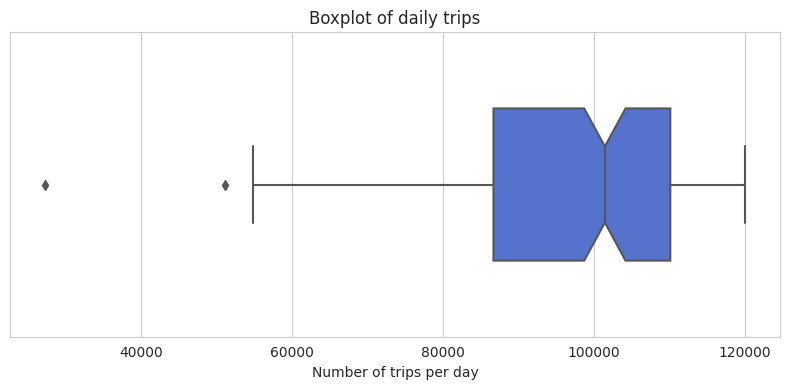

In [30]:
# Boxplot of daily number of trips

fig, ax = plt.subplots(figsize = (8,4))
# Create the boxplot
ax = sns.boxplot(taxi_group_date_idx, x='Number_of_Pickups', color = 'royalblue', orient='h', width = .5, notch = True)
# Set the title and label
ax.set(xlabel= 'Number of trips per day',title= "Boxplot of daily trips")

plt.tight_layout()
plt.show()

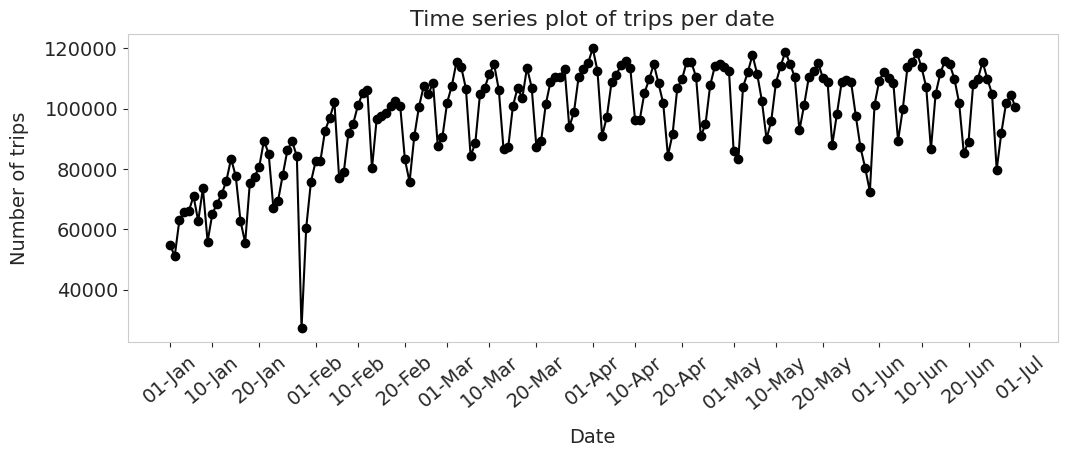

In [35]:
# Time series plot of trips per date

plt.figure(figsize = (12,4), dpi = 100)

# Assign the values to be displayed on the x-axis and y-axis
x = taxi_group_date['Date']
y = taxi_group_date['Number_of_Pickups']

# Create the time series plot
plt.plot_date(x, y, color = 'black', linestyle = 'solid', linewidth = 1.5)

# Set the title and labels of the plot
plt.title("Time series plot of trips per date", fontsize = 16)
plt.xlabel("Date", fontsize = 14, labelpad = 11)
plt.ylabel("Number of trips", fontsize = 14, labelpad = 11)

# Define the locator for major ticks on the x-axis on the 1st, 10th and 20th day of each month
day_locator = mdates.DayLocator(bymonthday=( 1, 10, 20))
# Define the locator for minor ticks on the x-axis
month_locator = mdates.MonthLocator()
# Define the formatter for the x-axis labels to display the day and abbreviated month
date_formatter = mdates.DateFormatter('%d-%b')

# Configure the x-axis tick locators and formatters
plt.gca().xaxis.set_major_locator(day_locator)
plt.gca().xaxis.set_minor_locator(month_locator)
plt.gca().xaxis.set_major_formatter(date_formatter)
plt.xticks(rotation= 40, fontsize = 14)
plt.yticks(fontsize = 14)

ax = plt.gca()

# Turn off the gridlines
ax.grid(False)
# Specify the visibility of ticks
ax.tick_params(axis='both', which='both', bottom=True, left=True)

plt.savefig('Timeplot_trips_per_date.png', dpi = 300, bbox_inches = 'tight')
plt.show()

In [14]:
# Date with the fewest trips taken

print("Date with lowest number of trips:----")
print(taxi_group_date_idx[taxi_group_date_idx.Number_of_Pickups == taxi_group_date_idx.Number_of_Pickups.min()])

Date with lowest number of trips:----
            Number_of_Pickups
Date                         
2022-01-29              27282


In [15]:
# Date with the most trips taken

print("Date with highest number of trips:----")
print(taxi_group_date_idx[taxi_group_date_idx.Number_of_Pickups == taxi_group_date_idx.Number_of_Pickups.max()])

Date with highest number of trips:----
            Number_of_Pickups
Date                         
2022-04-01             119976


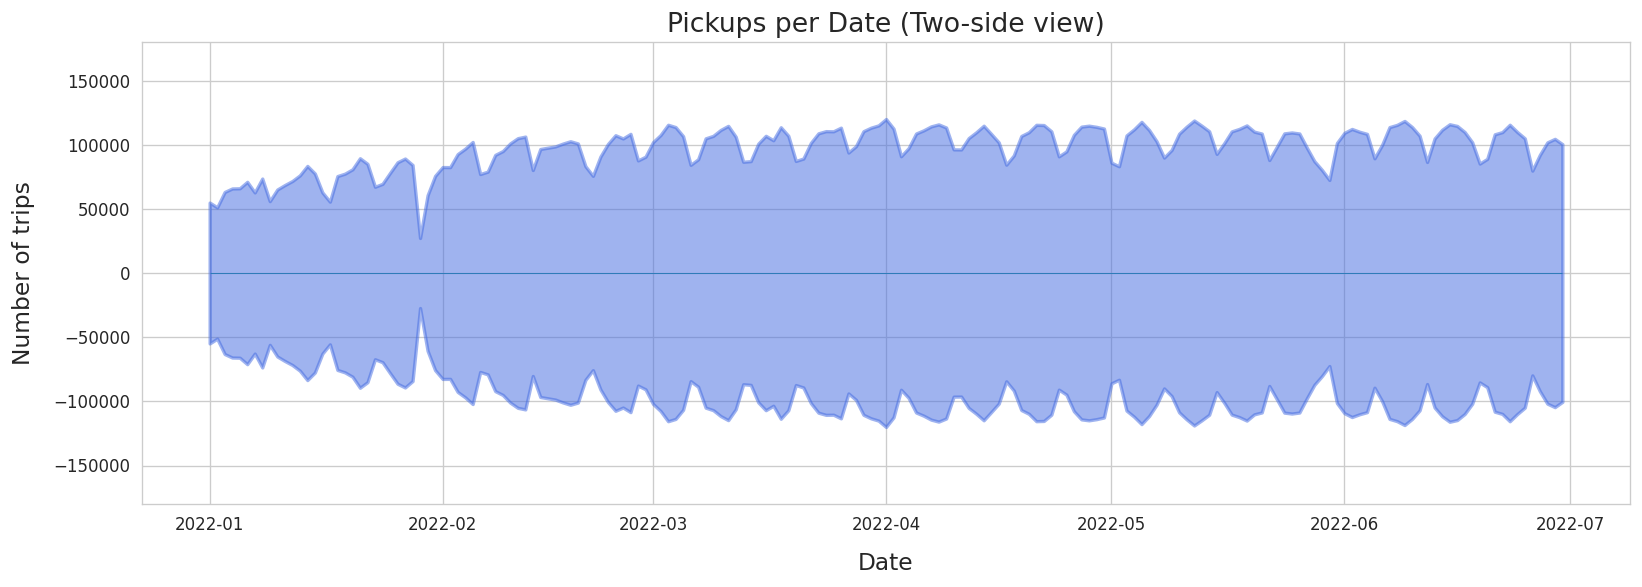

In [16]:
# Excerpt trend patterns in the analyzed time period
# Since all values are positive, demand is shown on both sides of the y-axis to emphasize the growth

sns.set_style("whitegrid")
x = taxi_group_date['Date'].values
y1 = taxi_group_date['Number_of_Pickups'].values

fig, ax = plt.subplots(1,1, figsize = (16,5), dpi = 120)
plt.fill_between(x, y1= y1, y2 = -y1, alpha = .5, linewidth = 2, color = 'royalblue')

plt.ylim (-180000, 180000)
plt.title("Pickups per Date (Two-side view)", fontsize = 16)
plt.xlabel("Date", fontsize = 14, labelpad = 11)
plt.ylabel("Number of trips", fontsize = 14, labelpad = 11)
plt.hlines(y = 0, xmin = np.min(taxi_group_date['Date']), xmax = np.max(taxi_group_date['Date']), linewidth = .5)
plt.show()

### Semi-annual distribution of taxi demand

The second step in understanding temporal patterns involves a closer investigation of demand across the specified period of six months.

In [36]:
# Create a helper dataframe that displays the number of trips aggregated per month
taxi_group_date['Date'] = pd.to_datetime(taxi_group_date['Date'])
taxi_group_date['Month'] = taxi_group_date['Date'].dt.month

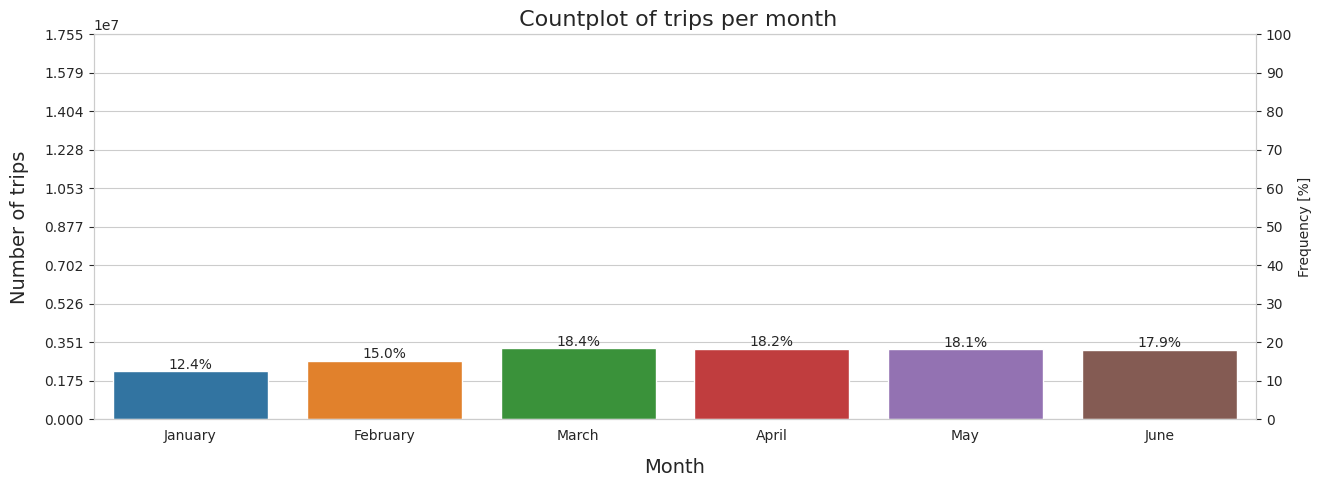

In [38]:
# Countplot of trip demand over the first half of the year

# Calculate the number of rows in the 'taxi_data_outl' dataframe
ncount = len(taxi_data_outl)

f = plt.figure(figsize = (15,5))
sns.set_style("whitegrid")

# Create the countplot
ax = sns.countplot(x = taxi_data_outl['PU_month'], data = taxi_data_outl)

# Add the title, labels and ticks
plt.title(" Countplot of trips per month", fontsize = 16)
plt.xlabel("Month", fontsize = 14, labelpad = 11)
plt.xticks(range(0,6), PU_month_names)
plt.ylabel("Number of trips", fontsize = 14, labelpad = 11)
ax2 = ax.twinx()
ax2.set_ylabel("Frequency [%]")

# Annotate each bar in the plot with the percentage of its height relative to the total count
# Iterate over each patch (bar) in the plot
for p in ax.patches:
    # Retrieve the coordinates of the bounding box of the current patch (bar)
    x = p.get_bbox().get_points()[:, 0]
    y = p.get_bbox().get_points()[1,1]
    # Add the annotation to the plot, displaying the percentage values
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), ha = 'center', va = 'bottom')

# Specify that there should be 11 evenly spaced major ticks on the y-axis
ax.yaxis.set_major_locator(ticker.LinearLocator(11))
# Set the y-axis limits
ax2.set_ylim(0, 100)
ax.set_ylim(0, ncount)

# Draw the gridlines below the other plot elements
ax2.set_axisbelow(True)
# Set the major tick locator at intervals of 10 on the y-axis
ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax2.grid(None)
plt.show()

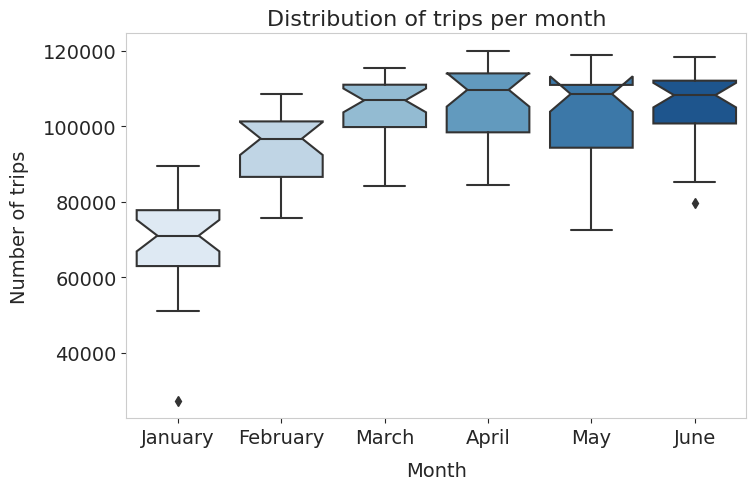

In [24]:
# Boxplot of the number of trips per month

fig, ax = plt.subplots(figsize = (8,5))
# Create the plot
ax = sns.boxplot(x= 'Month', y= "Number_of_Pickups", data = taxi_group_date, notch = True, palette = 'Blues')

# Remove gridlines
ax.grid(False, which = 'both')
# Add the ticks on the x-axis
ax.tick_params(axis='x', which='both', bottom=True) 
# Add the ticks on the y-axis
ax.tick_params(axis='y', which='both', left=True) 

# Plot the title and labels
plt.title("Distribution of trips per month", fontsize = 16)
plt.xlabel("Month", fontsize = 14, labelpad = 10)
plt.ylabel("Number of trips", fontsize = 14, labelpad = 10)
# Display the full name of the month
xvalues = ["January", "February", "March", "April", "May", "June"]

# Adjust the tickmarks
plt.xticks(np.arange(6), xvalues, fontsize = 14)
plt.yticks(fontsize = 14)

plt.savefig('Boxplot_trips_per_month.png', dpi = 300, bbox_inches='tight')
plt.show()

### Monthly distribution of taxi demand

The third step in understanding temporal patterns involves investigating how the demand varies across each day of the month.

In [25]:
# Create a helper dataframe that displays the number of trips for each day of the month

day_of_month = taxi_data_outl['PU_day_of_month']
taxi_group_day_of_month = date.groupby(day_of_month).agg('count').reset_index(name = 'Number_of_Pickups')
taxi_group_day_of_month.columns = ['Day_of_month', 'Number_of_Pickups']

# Set the day of the month as index

taxi_group_day_of_month_idx = taxi_group_day_of_month.set_index('Day_of_month')

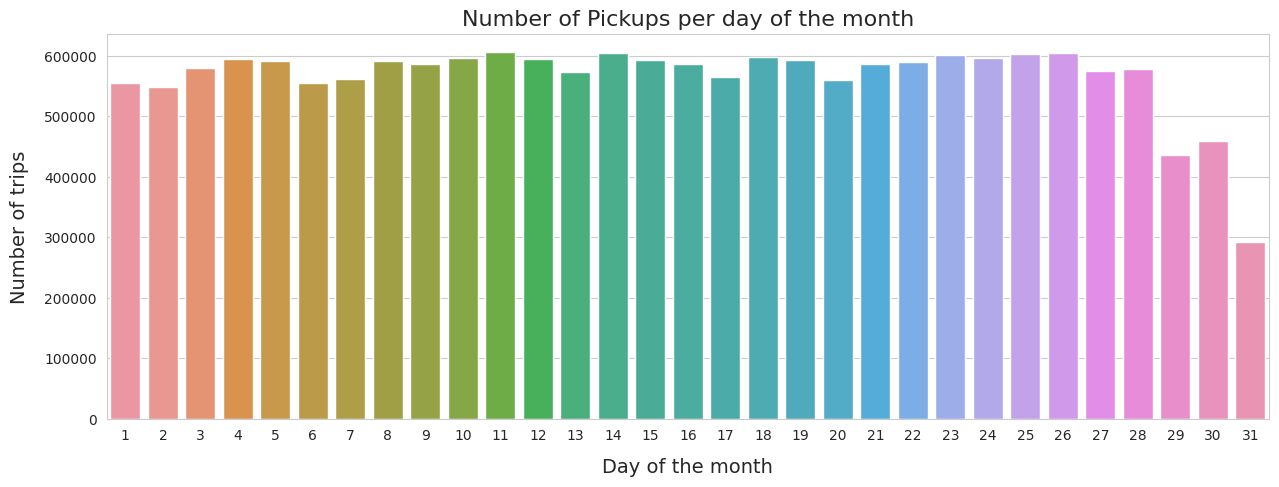

In [26]:
# Countplot of trips per day of the month

f = plt.figure(figsize = (15,5))
sns.countplot(x = taxi_data_outl['PU_day_of_month'], data = taxi_data_outl)
plt.title("Number of Pickups per day of the month", fontsize = 16)
plt.xlabel("Day of the month", fontsize = 14, labelpad = 11)
plt.ylabel("Number of trips", fontsize = 14, labelpad = 11)
plt.show()

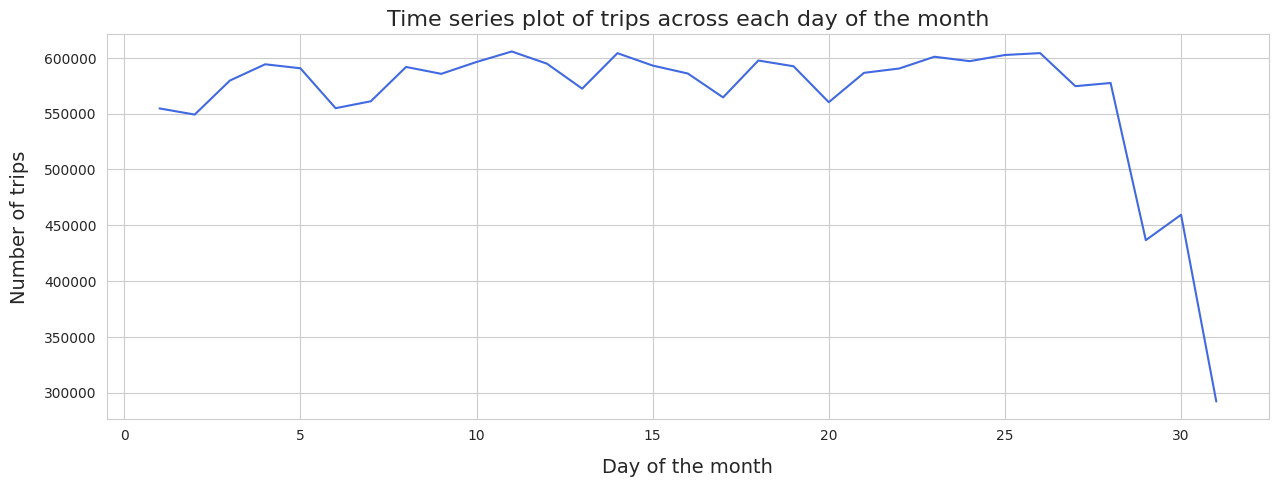

In [27]:
# Time series plot of trips per day of the month

plt.figure(figsize = (15,5), dpi = 100)
x = taxi_group_day_of_month['Day_of_month']
y = taxi_group_day_of_month['Number_of_Pickups']
plt.plot(x, y, color = 'royalblue', linestyle = 'solid')

plt.title("Time series plot of trips across each day of the month", fontsize = 16)
plt.xlabel("Day of the month", fontsize = 14, labelpad = 11)
plt.ylabel("Number of trips", fontsize = 14, labelpad = 11)
plt.show()

### Weekly distribution of taxi demand

In the fourth step, the weekly distribution of taxi demand is investigated.

In [28]:
# Create a helper dataframe that displays the number of trips for each day of the week

taxi_group_date['Date'] = pd.to_datetime(taxi_group_date['Date'])
taxi_group_date['Weekday'] = taxi_group_date['Date'].dt.weekday

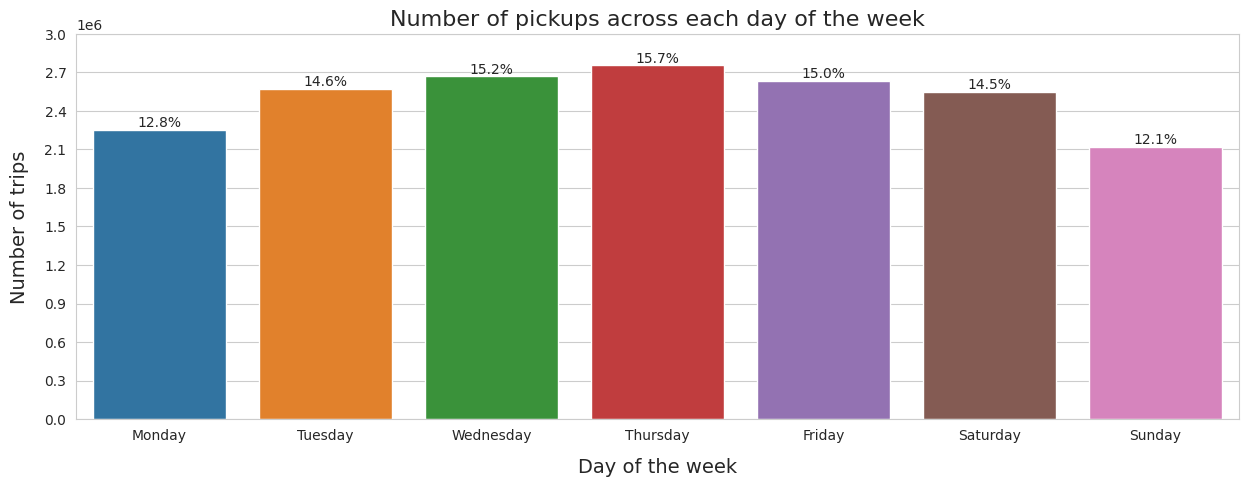

In [29]:
# Countplot of trips per day of the week 

f = plt.figure(figsize = (15,5))
ax = sns.countplot(x = 'PU_day_of_week', data = taxi_data_outl)

plt.title("Number of pickups across each day of the week", fontsize = 16)
plt.xlabel("Day of the week", fontsize = 14, labelpad = 11)
plt.ylabel("Number of trips", fontsize = 14, labelpad = 11)
plt.xticks(range(0,7), PU_day_of_week_names)

# Annotate each bar in the plot with the percentage of its height relative to the total count
# Iterate over each patch (bar) in the plot
for p in ax.patches:
    # Retrieve the coordinates of the bounding box of the current patch (bar)
    x = p.get_bbox().get_points()[:, 0]
    y = p.get_bbox().get_points()[1,1] 
    # Add the annotation to the plot, displaying the percentage values 
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), ha = 'center', va = 'bottom')
    
ax.yaxis.set_major_locator(ticker.LinearLocator(11))
ax.set_ylim(0, 3000000)
plt.show()

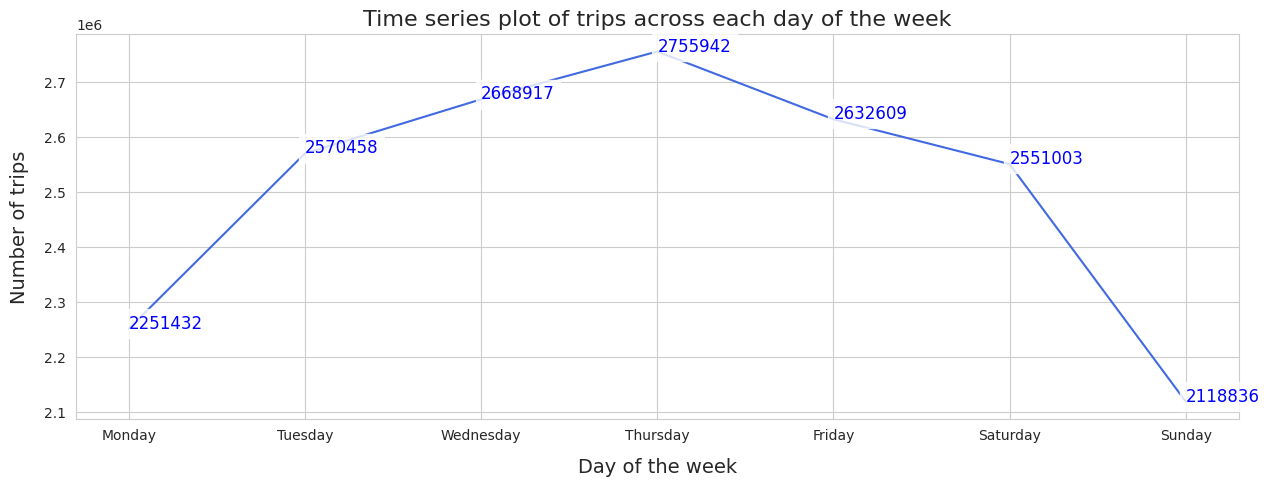

In [39]:
# Time series plot of trips across each day of the week

# Group the data by 'PU_day_of_week' column and calculate the size (count) of each group
taxi_group_day = taxi_data_outl.groupby(taxi_data_outl['PU_day_of_week']).size().reset_index()
# Rename the column
taxi_group_day.rename(columns = {0: 'Number_of_Pickups'}, inplace = True)

plt.figure(figsize = (15,5), dpi = 100)
x = taxi_group_day['PU_day_of_week']
y = taxi_group_day ['Number_of_Pickups']

ax = plt.plot(x, y, color = 'royalblue', linestyle = 'solid')

plt.title("Time series plot of trips across each day of the week", fontsize = 16)
plt.xlabel("Day of the week", fontsize = 14, labelpad =11)
plt.ylabel("Number of trips", fontsize = 14, labelpad =11)
plt.xticks(np.arange(7), PU_day_of_week_names)


# Iterate over each data point and add a text annotation to the plot, displaying the number of pickups above each datapoint
for x,y in zip(taxi_group_day['PU_day_of_week'], taxi_group_day['Number_of_Pickups']):
    plt.text(x = x,
             y = y+500, 
             s = '{:.0f}'.format(y),
             color = 'blue',
             fontsize = 12,
             bbox = dict(facecolor='white', alpha=0.8))
plt.show()

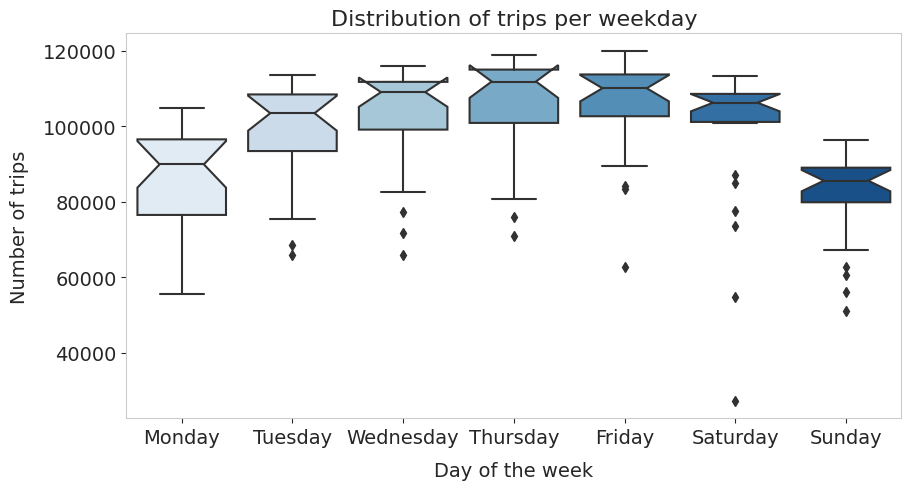

In [46]:
# Boxplot of pickups per weekday

fig, ax = plt.subplots(figsize = (10,5))
ax = sns.boxplot(x = 'Weekday', y = 'Number_of_Pickups', data = taxi_group_date, notch = True, palette = 'Blues')

# Add title and axis labels
plt.title("Distribution of trips per weekday", fontsize = 16)
plt.xlabel("Day of the week", fontsize = 14, labelpad = 10)
plt.ylabel("Number of trips", fontsize = 14, labelpad = 10)

# Display the full name of the month and adjust the ticks 
xvalues = PU_day_of_week_names
plt.xticks(np.arange(7), xvalues, fontsize = 14)
plt.yticks(fontsize = 14)

# Remove gridlines
ax.grid(False, which = 'both')
# Add the ticks on the x-axis
ax.tick_params(axis='x', which='both', bottom=True) 
# Add the ticks on the y-axis
ax.tick_params(axis='y', which='both', left=True) 

plt.savefig('Boxplot_trips_per_weekday.png', dpi = 300, bbox_inches='tight')
plt.show()

### Distribution of taxi demand across each time periods of the day

The fifth step aims to comprehend temporal demand variations across different times of the day.

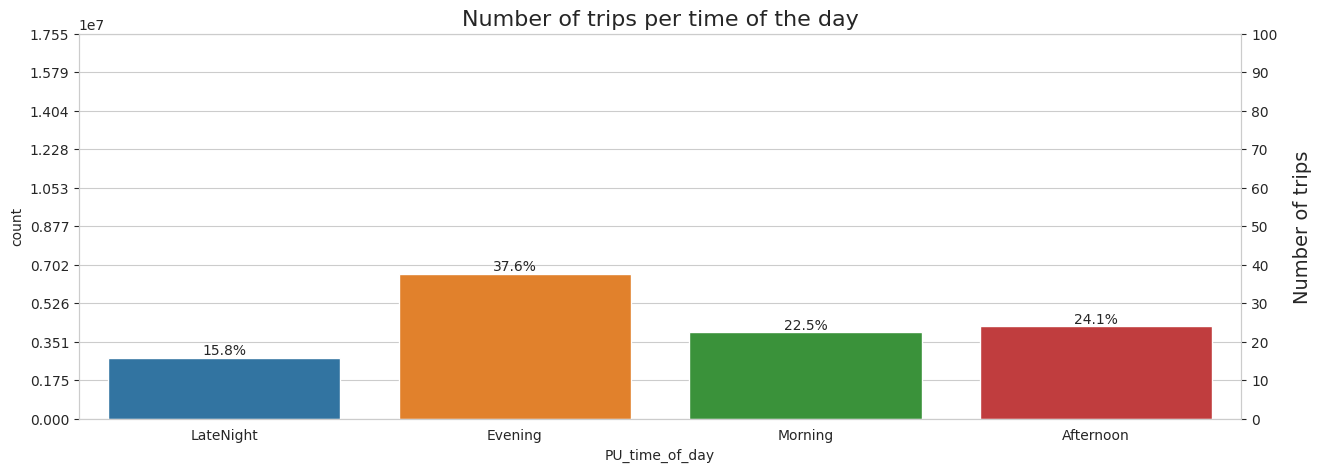

In [47]:
# Countplot of trips across each time of the day

f = plt.figure(figsize = (15,5))
ax = sns.countplot(x = 'PU_time_of_day', data = taxi_data_outl);
ax2 = ax.twinx()
ax2.set_ylabel("Frequency [%]")

plt.title("Number of trips per time of the day", fontsize = 16)
plt.xlabel("Time of the day", fontsize = 14, labelpad = 11)
plt.ylabel("Number of trips", fontsize = 14, labelpad = 11)

# Annotate each bar in the plot with the percentage of its height relative to the total count
# Iterate over each patch (bar) in the plot
for p in ax.patches:
    # Retrieve the coordinates of the bounding box of the current patch (bar)
    x = p.get_bbox().get_points()[:, 0]
    y = p.get_bbox().get_points()[1,1]
    # Add the annotation to the plot, displaying the percentage values 
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), ha = 'center', va = 'bottom')

ax.yaxis.set_major_locator(ticker.LinearLocator(11))
ax.set_ylim(0, ncount)
ax2.set_ylim(0, 100)
ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax2.grid(None)

plt.show()

### Hourly distribution of taxi demand

The sixth step focuses on investigating the distribution of taxi demand aggregated on an hourly basis.

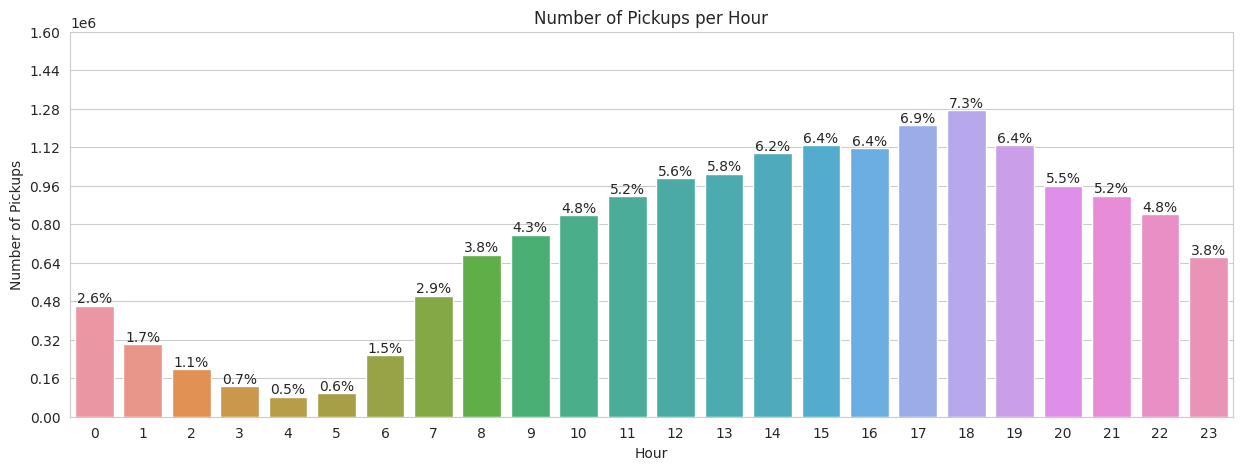

In [48]:
# Countplot of Pickups per Hour

f = plt.figure(figsize = (15,5))
ax = sns.countplot(x = 'PU_hour', data = taxi_data_outl);

plt.title("Number of Pickups per Hour")
plt.xlabel("Hour")
plt.ylabel("Number of Pickups")

# Annotate each bar in the plot with the percentage of its height relative to the total count
# Iterate over each patch (bar) in the plot
for p in ax.patches:
    # Retrieve the coordinates of the bounding box of the current patch (bar)
    x = p.get_bbox().get_points()[:, 0]
    y = p.get_bbox().get_points()[1,1]
    # Add the annotation to the plot, displaying the percentage values 
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), ha = 'center', va = 'bottom')

ax.yaxis.set_major_locator(ticker.LinearLocator(11))
ax.set_ylim(0, 1600000)
plt.show()

## Bivariate analysis

The bivariate analysis involves examining the relationship and interactions between two variables. By studying the relationship between two variables, bivariate analysis provides insights into their correlations, dependencies, or potential cause-and-effect relationships.

### Distribution of daily demand across each month

Examination of the distribution of daily demand across each month.

In [50]:
# Helper dataframe: Group the data by pickup day of the month and month
grouped_month_day = taxi_data_outl.groupby(["PU_day_of_month", "PU_month"]).size().reset_index(name="trips")

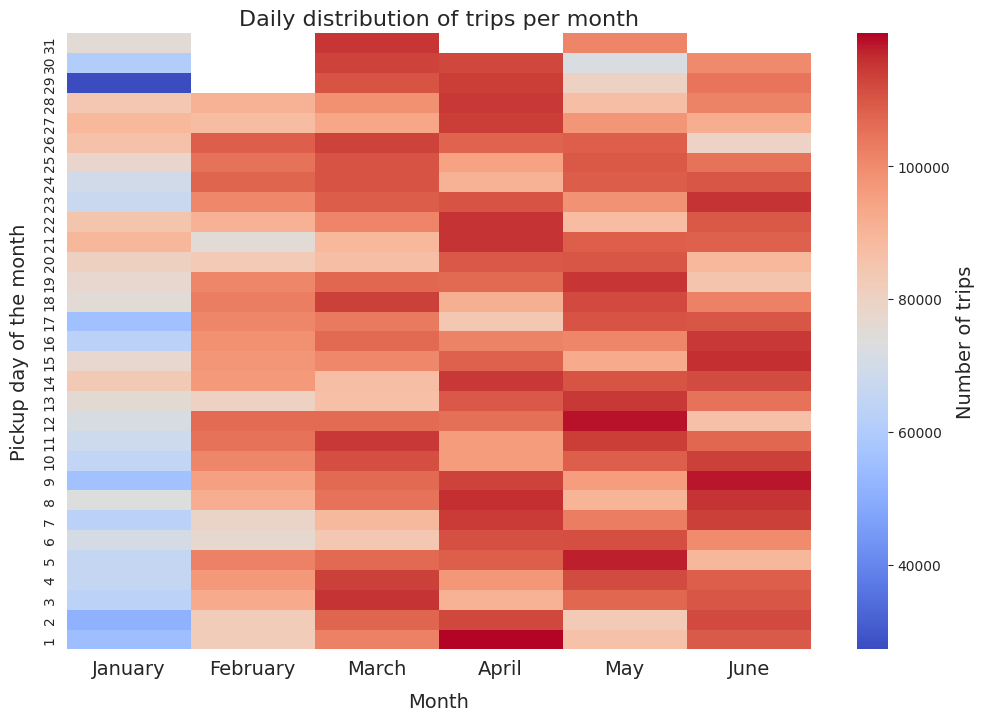

In [54]:
# Pivot the data to create a new dataframe with 'PU_day_of_month' as index, 'PU_month' as the columns, and 'trips' as values
pivot_month_day = grouped_month_day.pivot( "PU_day_of_month","PU_month", "trips")

# Reverse the order of rows in the dataframe to display the days of the month in descending order in the heatmap
pivot_month_day = pivot_month_day.iloc[::-1]

plt.figure(figsize=(12, 8))

# Create the heatmap
heatmap = sns.heatmap(pivot_month_day, cmap="coolwarm", cbar_kws={'label': "Number of trips"})

# Set the title, labels and ticks 
heatmap.set_title("Daily distribution of trips per month", fontsize=16)
heatmap.set_ylabel("Pickup day of the month", fontsize = 14, labelpad = 10)
heatmap.set_yticks(np.arange(31) + 0.5)
heatmap.set_yticklabels(reversed(range(1, 32)))
heatmap.set_xlabel("Month", fontsize = 14, labelpad = 10)
heatmap.set_xticks(np.arange(len(PU_month_names)) + 0.5)
heatmap.set_xticklabels(PU_month_names, fontsize = 14)

# Add color bar labels for the y-axis
cbar = heatmap.collections[0].colorbar
cbar.ax.set_ylabel('Number of trips', fontsize=14)

plt.savefig('Heatmap_day_of_month_month.png', dpi=300, bbox_inches='tight')
plt.show()

### Hourly demand distribution across each weekday

Examination of the hourly demand distribution across each weekday.

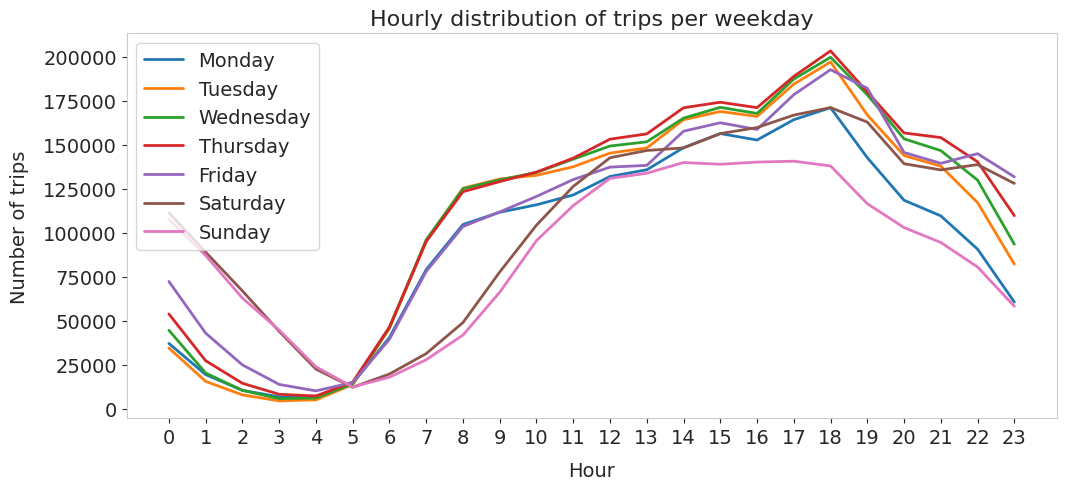

In [57]:
# Create a helper dataframe to group the data by pickup day of the week and pickup hour
grouped_weekday_hour = taxi_data_outl.groupby(["PU_day_of_week", "PU_hour"]).size().reset_index(name="trips")

# Time series plot for the hourly distribution of trips per weekday
plt.figure(figsize=(12,5))

# Iterate over each unique day of the week 
for i, day_of_week in enumerate(grouped_weekday_hour["PU_day_of_week"].unique()):
    # Create a subset of the 'grouped_weekday_hour' dataframe where the 'PU_day_of_week' column matches the current day of the week
    subset = grouped_weekday_hour[grouped_weekday_hour["PU_day_of_week"] == day_of_week]
    # Plot the line graph corresponding to the day of the week using the 'PU_day_of_week_names' list
    plt.plot(subset["PU_hour"], subset["trips"], label=PU_day_of_week_names[day_of_week], linewidth = 2)

# Create and adjust the title, labels, ticks and legend
plt.title("Hourly distribution of trips per weekday", fontsize = 16)
plt.xlabel("Hour", fontsize = 14, labelpad = 10)
plt.xticks(np.arange(24), np.arange(24), fontsize = 14)
plt.ylabel("Number of trips", fontsize = 14, labelpad = 10)
plt.yticks(fontsize = 14)
plt.legend(fontsize = 14)

# Remove gridlines
plt.grid(False, which='both')
# Add the ticks on the x-axis
plt.tick_params(axis='x', which='both', bottom=True)
# Add the ticks on the y-axis
plt.tick_params(axis='y', which='both', left=True)

plt.savefig('Seasonal_plot_hour_weekday.png', dpi = 300, bbox_inches='tight')
plt.show()

In [58]:
# Helper dataframe: Compute the number of pickups at each hour throughout the week

PU_count = pd.crosstab(taxi_data_outl['PU_day_of_week'], taxi_data_outl['PU_hour'])
PU_count = PU_count.set_axis(PU_day_of_week_names, axis = 'index')

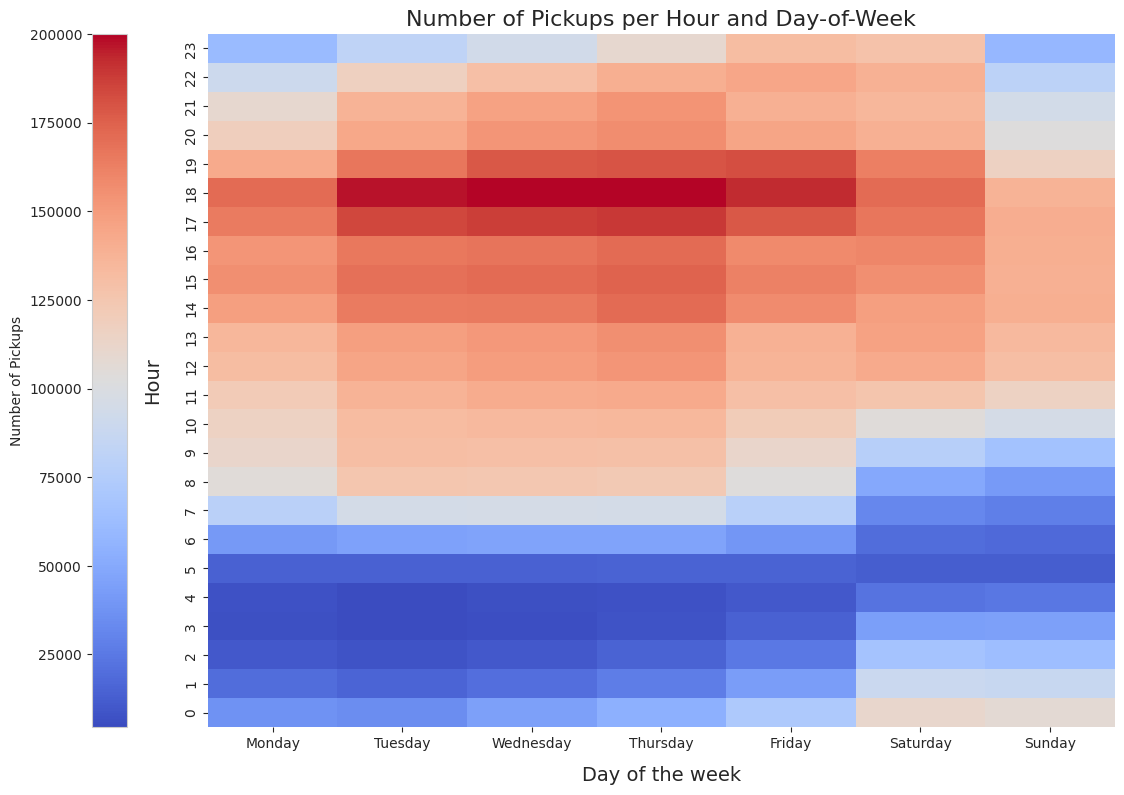

In [59]:
# Heatmap of hourly distribution of trips across each weekday

fig, ax = plt.subplots(figsize = (15,9))
ax = sns.heatmap(PU_count.transpose(), cmap = "coolwarm", vmax = 200000, cbar = False);
fig.colorbar(ax.collections[0], label = "Number of Pickups", ax = ax, location = "left", use_gridspec = False, pad = 0.07)
ax.yaxis.tick_left()
ax.invert_yaxis()
ax.xaxis.tick_bottom()
ax.tick_params(axis = 'y', rotation = 90)
ax.set_title("Number of Pickups per Hour and Day-of-Week", fontsize = 16)
plt.xlabel("Day of the week", fontsize = 14, labelpad = 11)
plt.ylabel("Hour", fontsize = 14, labelpad = 16)

plt.show()

### Weekday demand distribution for each time of the day

In [60]:
# Create a helper dataframe that displays the number of trips across each weekday and time of the day
weekday_time_of_day_helper = pd.crosstab(taxi_data_outl['PU_day_of_week'], taxi_data_outl['PU_time_of_day'])

# Stacked weekday time-of-the-day distribution 
stacked_weekday_time_of_day_helper = weekday_time_of_day_helper.stack().reset_index().rename(columns ={0:'Number_of_Pickups'})
time_of_day_order = ['LateNight', 'Morning', 'Afternoon', 'Evening']
stacked_weekday_time_of_day_helper.PU_time_of_day = pd.Categorical(stacked_weekday_time_of_day_helper.PU_time_of_day, categories = time_of_day_order)

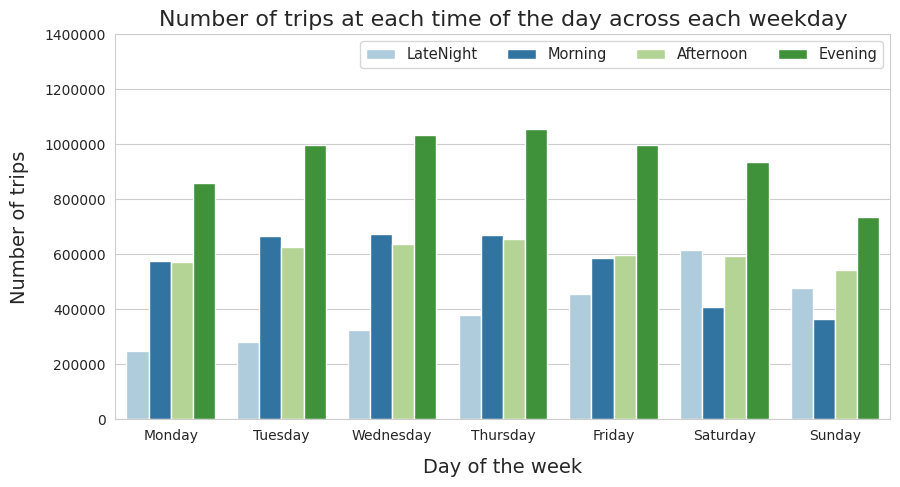

In [61]:
# Barplot of trip demand for each weekday and across each time of the day

fig, ax = plt.subplots(figsize = (10,5))
sns.barplot(x = stacked_weekday_time_of_day_helper.PU_day_of_week, y = stacked_weekday_time_of_day_helper.Number_of_Pickups, hue = stacked_weekday_time_of_day_helper.PU_time_of_day, ax = ax, palette = 'Paired')

ax.set_title("Number of trips at each time of the day across each weekday", fontsize = 16)
ax.set_xlabel("Day of the week", fontsize = 14, labelpad = 11)
ax.set_ylabel("Number of trips", fontsize = 14, labelpad = 11)
ax.set_xticklabels(PU_day_of_week_names)
plt.ticklabel_format(style = 'plain', axis = 'y')
plt.ylim(0, 1400000)
plt.legend(loc = 1, ncol = len(stacked_weekday_time_of_day_helper.PU_time_of_day), prop = {'size': 10.5})
plt.show()

# Loading and exploring geospatial information of NYC taxi zones

Furthermore, in addition to the temporal analysis of taxi demand, a spatial analysis is performed. The [TLC](https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page) provides supplementary geospatial information for each taxi zone in the [Taxi_Zone_Shapefile](https://d37ci6vzurychx.cloudfront.net/misc/taxi_zones.zip), including: 
<ul>
    <li> Shape_Leng and Shape_Area: The length and area measurements of the taxi zone's shape or boundary. </li>
    <li> Zone: The name assigned to each taxi zone.</li>
    <li> LocationID:Each taxi zone is assigned a unique LocationID, which serves as a reference for identification purpose.</li>
    <li> Borough: Specification of the borough to which the taxi zone belongs.</li>
    <li> Geometry: Polygon and Multipolygon coordinates to represent the shape and position of the taxi zone.</li>
</ul>

In [63]:
# Read geographic information on the taxi zones of NYC

taxi_zones = gpd.read_file("gs://taxi_data_outl/taxi_zones/taxi_zones.dbf")

In [64]:
# Head of the dataframe 

taxi_zones.head()

,OBJECTID,Shape_Leng,Shape_Area,zone,LocationID,borough,geometry
0,1,0.116357,0.000782,Newark Airport,1,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,0.433470,0.004866,Jamaica Bay,2,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,0.084341,0.000314,Allerton/Pelham Gardens,3,Bronx,"POLYGON ((1026308.770 256767.698, 1026495.593 ..."
3,4,0.043567,0.000112,Alphabet City,4,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,0.092146,0.000498,Arden Heights,5,Staten Island,"POLYGON ((935843.310 144283.336, 936046.565 14..."


In [65]:
# Shape of the dataframe

taxi_zones.shape

(263, 7)

In [66]:
# Type of the dataframe

print(type(taxi_zones))

<class 'geopandas.geodataframe.GeoDataFrame'>


This is a geopandas GeoDataFrame.

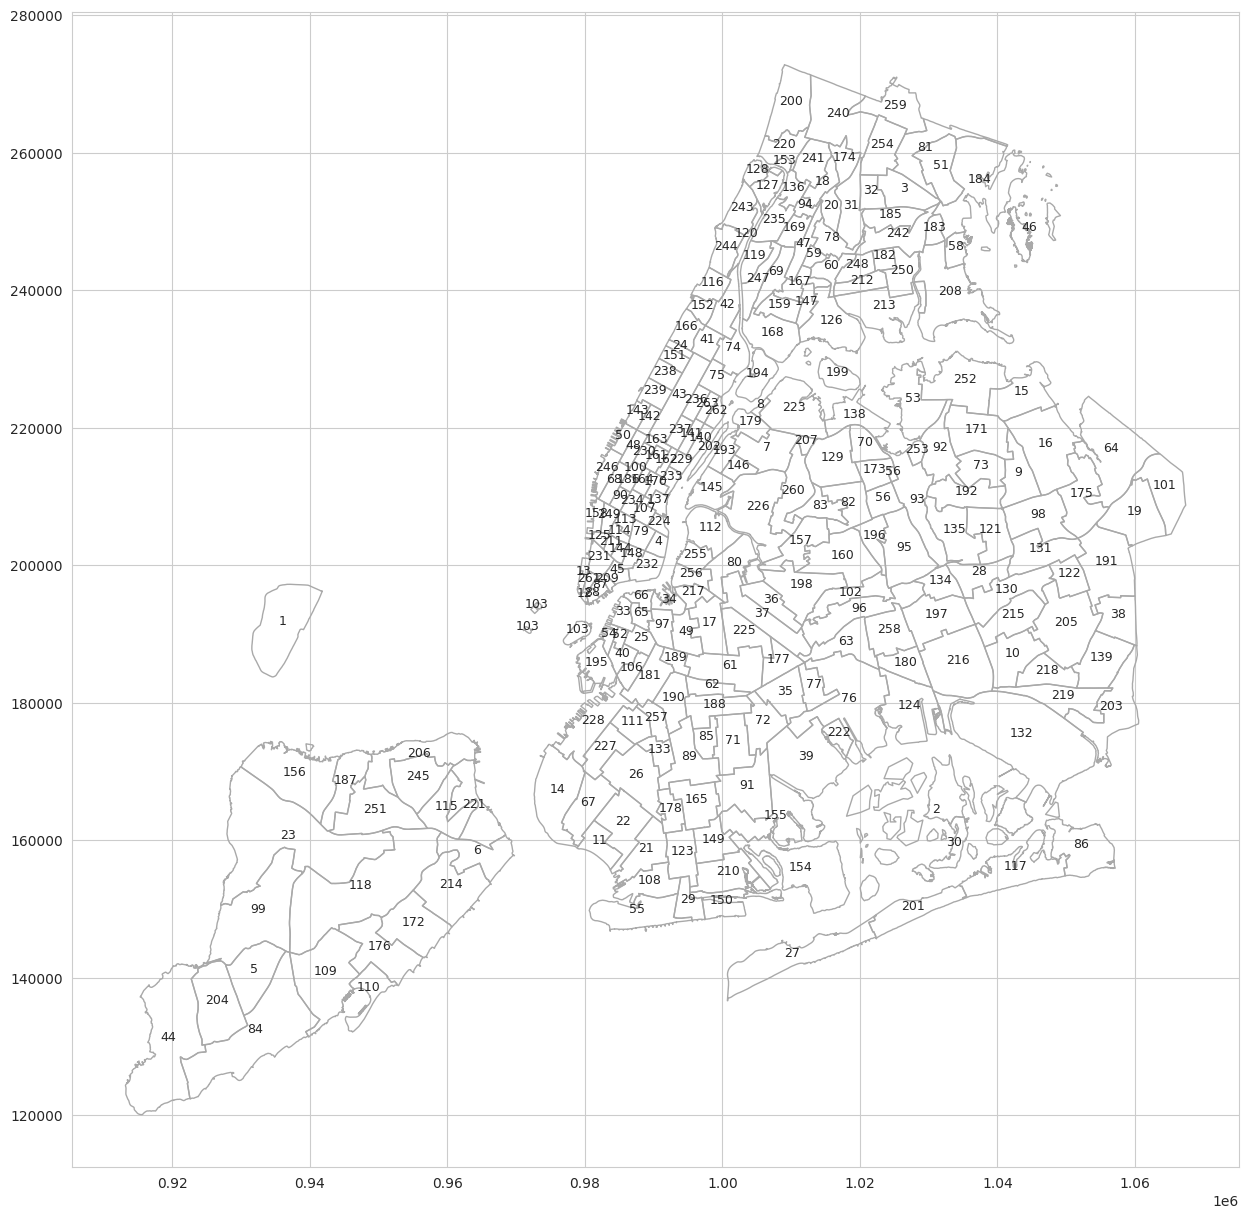

In [67]:
# Plot of all existing taxi zones in New York City

ax = taxi_zones.plot(figsize = (20,15), color = 'none', edgecolor = 'darkgrey', column = 'borough', zorder = 3)
taxi_zones.apply(lambda x: ax.annotate(text = x['LocationID'], xy = x.geometry.centroid.coords[0], ha = 'center', fontsize = 9), axis = 1);
plt.show()

In [68]:
# How many locations belong to each borough?

taxi_zones.borough.value_counts()

Queens           69
Manhattan        69
Brooklyn         61
Bronx            43
Staten Island    20
EWR               1
Name: borough, dtype: int64

#  Spatial analysis of MOD requests

To analyze the geospatial distribution of taxi demand, it is necessary to merge the dataframe of taxi trip records with the taxi zones dataset.

In [69]:
# Prepare the data for the subsequent merge

PU_count_per_locationID = taxi_data_outl.groupby(['PULocationID'], as_index = False).size()

In [70]:
# Check if there are LocationIDs with zero Pickups

# Define a function that takes in a list of input and fings the missing elements within the range defined by the first and last element of the list
def find_missing(lst):
    start = lst[0]
    end = lst[-1]
    return sorted(set(range(start, end + 1)).difference(lst))
 
# Driver code that calls the function with the list of pickup locations as argument
lst = list(PU_count_per_locationID['PULocationID'])

# Print the missing elements in the list
print(find_missing(lst))

[103, 104, 110]


There is no taxi demand at pickup locations 103, 104, and 110.

In [71]:
# Merge of the Dataframes based on the column 'PULocationID' and 'LocationID'
total_PU_per_location = gpd.GeoDataFrame(pd.merge(PU_count_per_locationID, taxi_zones, left_on = 'PULocationID', right_on = 'LocationID')).drop('LocationID', axis = 1)
total_PU_per_location.head()

,PULocationID,size,OBJECTID,Shape_Leng,Shape_Area,zone,borough,geometry
0,1,105,1,0.116357,0.000782,Newark Airport,EWR,"POLYGON ((933100.918 192536.086, 933091.011 19..."
1,2,14,2,0.433470,0.004866,Jamaica Bay,Queens,"MULTIPOLYGON (((1033269.244 172126.008, 103343..."
2,3,169,3,0.084341,0.000314,Allerton/Pelham Gardens,Bronx,"POLYGON ((1026308.770 256767.698, 1026495.593 ..."
3,4,17049,4,0.043567,0.000112,Alphabet City,Manhattan,"POLYGON ((992073.467 203714.076, 992068.667 20..."
4,5,185,5,0.092146,0.000498,Arden Heights,Staten Island,"POLYGON ((935843.310 144283.336, 936046.565 14..."


### Identification of high-demand areas

In [72]:
# Top 10 locations with the highest number of pickups
total_PU_per_location_sorted = total_PU_per_location.sort_values(by = 'size', ascending = False)
total_PU_per_location_sorted.head(10)

,PULocationID,size,OBJECTID,Shape_Leng,Shape_Area,zone,borough,geometry
232,237,860611,237,0.042213,0.000096,Upper East Side South,Manhattan,"POLYGON ((993633.442 216961.016, 993507.232 21..."
127,132,779258,132,0.245479,0.002038,JFK Airport,Queens,"MULTIPOLYGON (((1032791.001 181085.006, 103283..."
231,236,775575,236,0.044252,0.000103,Upper East Side North,Manhattan,"POLYGON ((995940.048 221122.920, 995812.322 22..."
156,161,720528,161,0.035804,0.000072,Midtown Center,Manhattan,"POLYGON ((991081.026 214453.698, 990952.644 21..."
137,142,596255,142,0.038176,0.000076,Lincoln Square East,Manhattan,"POLYGON ((989380.305 218980.247, 989359.803 21..."
181,186,589190,186,0.024696,0.000037,Penn Station/Madison Sq West,Manhattan,"POLYGON ((986752.603 210853.699, 986627.863 21..."
157,162,588106,162,0.035270,0.000048,Midtown East,Manhattan,"POLYGON ((992224.354 214415.293, 992096.999 21..."
165,170,557730,170,0.045769,0.000074,Murray Hill,Manhattan,"POLYGON ((991999.299 210994.739, 991972.635 21..."
225,230,554929,230,0.031028,0.000056,Times Sq/Theatre District,Manhattan,"POLYGON ((988786.877 214532.094, 988650.277 21..."
47,48,552615,48,0.043747,0.000094,Clinton East,Manhattan,"POLYGON ((986694.313 214463.846, 986568.184 21..."


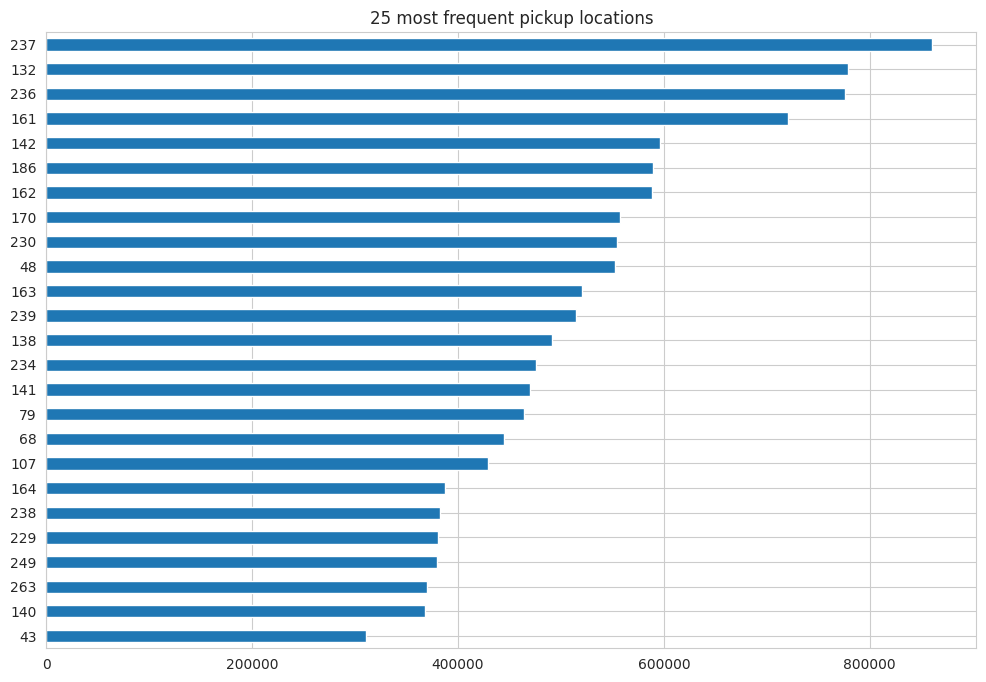

In [73]:
# Barplot of the 25 most frequent pickup locations
taxi_data_outl['PULocationID'].value_counts().head(25).sort_values().plot(kind = 'barh', title = '25 most frequent pickup locations', figsize =(12,8))
plt.show()

<AxesSubplot:>

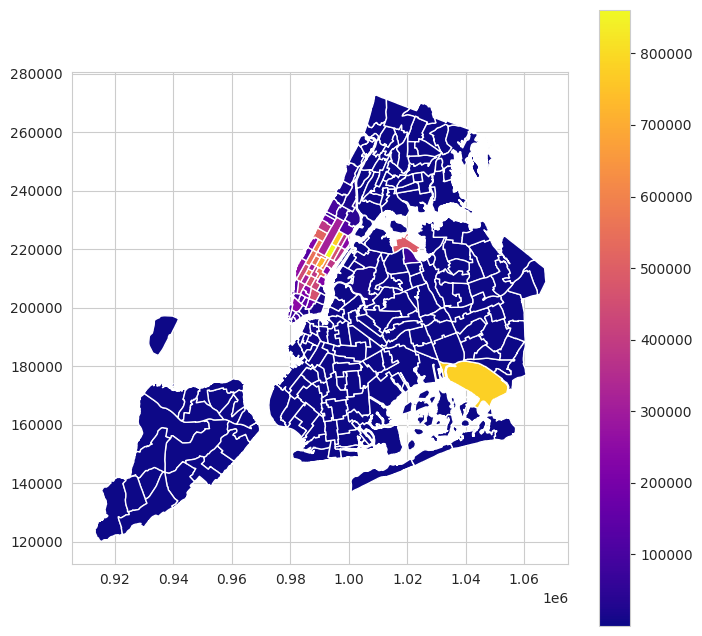

In [74]:
# Geospatial plot of the number of pickups per LocationID

total_PU_per_location_sorted[['PULocationID', 'size', 'zone', 'borough', 'geometry']].plot(figsize = (8,8),
                                                                                           column = 'size', 
                                                                                           cmap = 'plasma', 
                                                                                           legend = True)

In [75]:
# Add a basemap using the contextily library
# Use of projected coordinate system / preproject to Web Mercator 

total_PU_per_location_sorted_web_mercator = total_PU_per_location_sorted.to_crs(epsg = 3857)

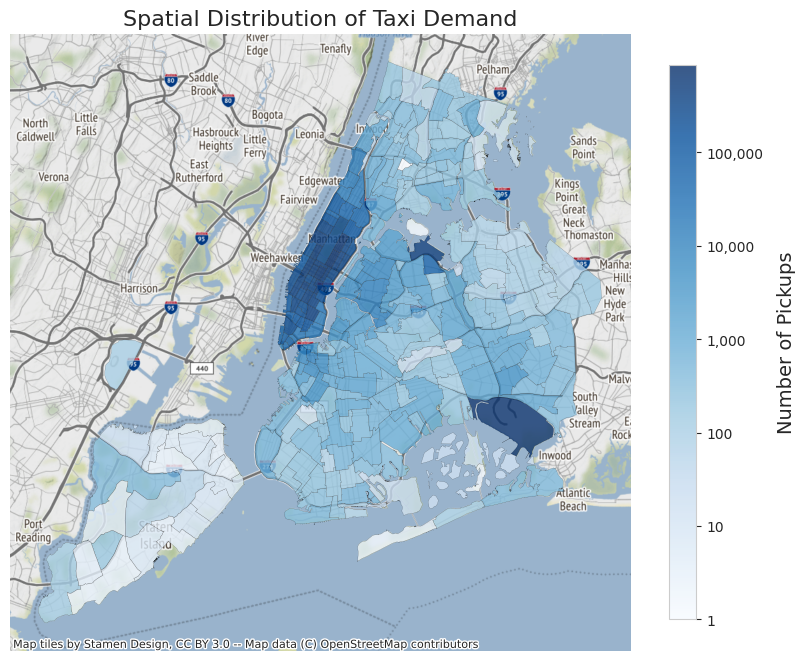

In [77]:
# Geospatial visualization with normalized colorbar
fig, ax = plt.subplots(figsize=(10, 10))

# Turn off the axis
ax.axis('off')

# Determine the minimum and maximum values for the colorbar
vmin, vmax = total_PU_per_location_sorted_web_mercator['size'].min(), total_PU_per_location_sorted_web_mercator['size'].max()

# Plot the geospatial data with the normalized colorbar
pickup_count = total_PU_per_location_sorted_web_mercator.plot(ax=ax, column='size', linewidth=0.1, edgecolor='k', figsize=(10, 10),
                                                               norm=colors.LogNorm(vmin=vmin, vmax=vmax), cmap='Blues', legend=False, alpha=.8)

# Add a basemap to the plot
ctx.add_basemap(ax)

# Draw the colorbar
# Get the collection of plotted patches
patch_col = ax.collections[0]
cbar = plt.colorbar(patch_col, shrink=0.72, orientation='vertical', pad=0.05, format=ticker.FuncFormatter(lambda x, _: f"{x:,.0f}"))
# Set the label for the colorbar
cbar.ax.set_ylabel("Number of Pickups", fontsize=14, labelpad=10)
# Remove the small ticks on the colorbar
cbar.minorticks_off()

plt.title('Spatial Distribution of Taxi Demand', fontsize=16)
plt.savefig('Spatial_analysis.png', dpi=300)
plt.show()

### Spatial distribution of trips across each borough

In [78]:
# Number of trips per borough
PU_count_per_borough = total_PU_per_location.groupby('borough', as_index = False)['size'].sum()
print(PU_count_per_borough)

         borough      size
0          Bronx     16168
1       Brooklyn     89249
2            EWR       105
3      Manhattan  16021090
4         Queens   1422262
5  Staten Island       850


In [79]:
total = PU_count_per_borough['size'].sum()
print(total)

17549724


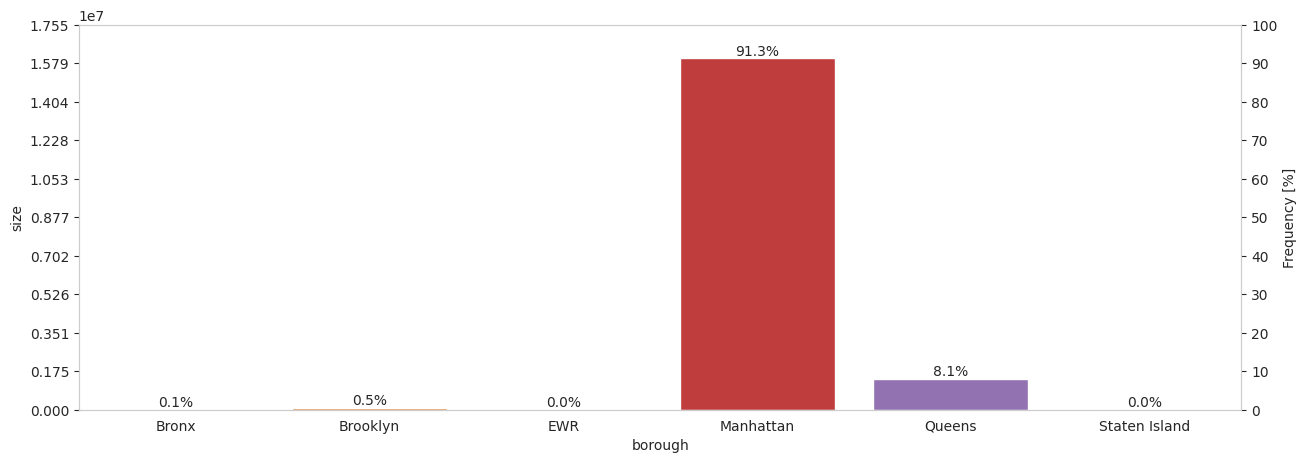

In [80]:
# Countplot of number of trips per borough

f = plt.figure(figsize=(15, 5))

# Create the barplot
ax = sns.barplot(x='borough', y='size', data=PU_count_per_borough)

# Create a twin axes object
ax2 = ax.twinx()
# Set the label for the secondary y-axis
ax2.set_ylabel("Frequency [%]")

# Loop to annotate each bar in the plot with the percentage of its height relative to the total count
# The annotation is placed at the center of each bar
for p in ax.patches:
    x = p.get_bbox().get_points()[:, 0]
    y = p.get_bbox().get_points()[1, 1]
    ax.annotate('{:.1f}%'.format(100. * y / total), (x.mean(), y), ha='center', va='bottom')

ax.yaxis.set_major_locator(ticker.LinearLocator(11))
ax.set_ylim(0, total)
ax2.set_ylim(0, 100)
ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))
ax2.grid(None)
ax.grid(False)

plt.xlabel("Borough")
plt.show()

**It is decided to limit the subsequent analyses to the borough of Manhattan.**

In [81]:
# Retrieve only the records from the dataframe that correspond to the borough of Manhattan

manhattan_data = total_PU_per_location_sorted[total_PU_per_location_sorted['borough'] == 'Manhattan']
manhattan_data.head()

,PULocationID,size,OBJECTID,Shape_Leng,Shape_Area,zone,borough,geometry
232,237,860611,237,0.042213,0.000096,Upper East Side South,Manhattan,"POLYGON ((993633.442 216961.016, 993507.232 21..."
231,236,775575,236,0.044252,0.000103,Upper East Side North,Manhattan,"POLYGON ((995940.048 221122.920, 995812.322 22..."
156,161,720528,161,0.035804,0.000072,Midtown Center,Manhattan,"POLYGON ((991081.026 214453.698, 990952.644 21..."
137,142,596255,142,0.038176,0.000076,Lincoln Square East,Manhattan,"POLYGON ((989380.305 218980.247, 989359.803 21..."
181,186,589190,186,0.024696,0.000037,Penn Station/Madison Sq West,Manhattan,"POLYGON ((986752.603 210853.699, 986627.863 21..."


In [82]:
# Create and return the PULocationIDs located in Manhattan from the dataframe as numpy array

unique_location_ids_manhattan = np.unique(manhattan_data['PULocationID'])
unique_location_ids_manhattan

array([  4,  12,  13,  24,  41,  42,  43,  45,  48,  50,  68,  74,  75,
        79,  87,  88,  90, 100, 107, 113, 114, 116, 120, 125, 127, 128,
       137, 140, 141, 142, 143, 144, 148, 151, 152, 153, 158, 161, 162,
       163, 164, 166, 170, 186, 194, 202, 209, 211, 224, 229, 230, 231,
       232, 233, 234, 236, 237, 238, 239, 243, 244, 246, 249, 261, 262,
       263], dtype=uint64)